In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import sys
sys.path.append("..")
import config as cfg

import pathlib

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [42]:
importlib.reload(cfg)

<module 'config' from '/home/nad/studies/Transformer-Image-Captioning-IIW/visualization/../config.py'>

In [43]:
device = "cpu"

model_folder = cfg.CONFIG_ROOT / "experiments/config_20260129-231542"
config = cfg.import_config(model_folder / 'config.json')
model_path = model_folder / 'cptr_best_meteor_model.pth'

In [44]:
if config['ENCODER_ARCH'] == cfg.EncoderArch.CNN_RESNET50:
    raise NotImplementedError("ResNet50 encoder is not supported for visualization.")

In [45]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [46]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading COCO dataset...


In [47]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=cfg.TOKENIZER_DATA_PATH, filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 8577, Pad token ID: 0


In [48]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))
transformer.eval()

model = transformer.encoder

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


In [49]:
model

ViTEncoder(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): G

In [50]:
if config['ENCODER_ARCH'] == cfg.EncoderArch.VIT_STYLE_BASE or config['ENCODER_ARCH'] == cfg.EncoderArch.VIT_STYLE_LARGE:
  for layer in model.vit.encoder.layer:
    layer.attention.attention.fused_attn = False
else:
  for layer in model.encoder_blocks:
    layer.MHSA.fused_attn = False

In [51]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    return img * IMAGENET_STD + IMAGENET_MEAN

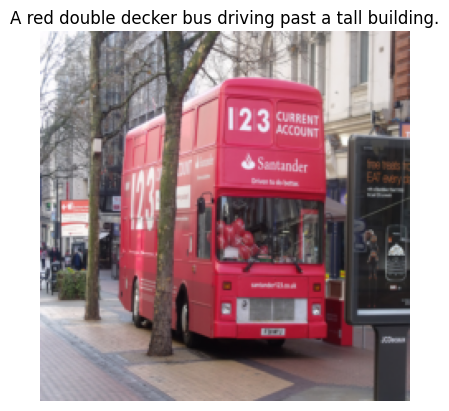

In [52]:
batch = next(iter(train_dataloader))
img_tensor = batch['pixel_values'][0].unsqueeze(0).to(device)
description = batch['description'][0]

# plot
img = denormalize(img_tensor[0].cpu())
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.title(description)
plt.show()

In [53]:
_, attn = model(img_tensor, return_attn=True)
for block in attn: # len(attn) == 12 (num of layers)
    print(block.shape)  # (batch_size, num_heads, seq_len, seq_len)

torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])


In [54]:
attn_last = attn[-1]          # only need last layer

attn_last_mean = attn_last.mean(dim=1)  # average heads → [B, 197, 197] for ViT, [B, 49, 49] for CPTR-CNN, [B, 196, 196] for Custom-CPTR

cls_attn_map = None
maps_cls = None
maps_processed_cls = None

if config['ENCODER_ARCH'] == cfg.EncoderArch.VIT_STYLE_BASE or config['ENCODER_ARCH'] == cfg.EncoderArch.VIT_STYLE_LARGE:
    cls_attn = attn_last_mean[:, 0, 1:]      # [B, 196] for ViT
    cls_attn_map = cls_attn.reshape(cls_attn.shape[0], 14, 14)

    patch_attn = attn_last_mean[:, 1:, 1:]  # [B, 196, 196]
    patch_saliency = patch_attn.sum(dim=1)  # [B, 196]
    patch_saliency_map = patch_saliency.reshape(patch_saliency.shape[0], 14, 14)

    # individual attention maps
    maps_cls = []
    for attn_head in attn_last[0]:  # attn_last: [B, num_heads, seq_len, seq_len]
        cls_attn_head = attn_head[0, 1:]  # [196]
        cls_attn_map_head = cls_attn_head.reshape(14, 14)
        maps_cls.append(cls_attn_map_head.detach().cpu())

    maps_patch = []
    for attn_head in attn_last[0]:  # attn_last: [B, num_heads, seq_len, seq_len]
        patch_attn_head = attn_head[1:, 1:]  # [196, 196]
        patch_siliency_head = patch_attn_head.sum(dim=0)  # [196]
        patch_siliency_map_head = patch_siliency_head.reshape(14, 14)
        maps_patch.append(patch_siliency_map_head.detach().cpu())
else:
    grid_size = int((attn_last_mean.shape[1])**0.5)  # 7 for CPTR-CNN, 14 for Custom-CPTR
    patch_attn = attn_last_mean # [B, 49, 49] for CPTR-CNN
    patch_saliency = attn_last_mean.sum(dim=1)  # [B, 49] for CPTR-CNN, [B, 196] for Custom-CPTR
    patch_saliency_map = patch_saliency.view(patch_saliency.shape[0], grid_size, grid_size)
    
    maps_patch = []
    for attn_head in attn_last[0]:  # [num_heads, 49, 49]
        patch_saliency_head = attn_head.sum(dim=0)  # [49]
        patch_saliency_map_head = patch_saliency_head.view(grid_size, grid_size)
        maps_patch.append(patch_saliency_map_head.detach().cpu())


In [55]:
if cls_attn_map is not None:
    cls_attn_map = torch.nn.functional.interpolate(
        cls_attn_map.unsqueeze(1),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(1)

patch_saliency_map = torch.nn.functional.interpolate(
    patch_saliency_map.unsqueeze(1),
    size=(H, W),
    mode="bilinear",
    align_corners=False
).squeeze(1)

if maps_cls is not None:
    maps_processed_cls = []
    for map in maps_cls:
        map = torch.nn.functional.interpolate(
            map.unsqueeze(0).unsqueeze(0),
            size=(H, W),
            mode="bilinear",
            align_corners=False
        ).squeeze(0).squeeze(0)
        maps_processed_cls.append(map.detach().numpy())

maps_processed_patch = []
for map in maps_patch:
    map = torch.nn.functional.interpolate(
        map.unsqueeze(0).unsqueeze(0),
        size=(H, W),
        mode="bilinear",
        align_corners=False
    ).squeeze(0).squeeze(0)
    maps_processed_patch.append(map.detach().numpy())

## CLS Attention Map - Global Aggregation Map

* Effectively visualizing:
    $$ A_{CLS \to patch} \in \mathbb{R}^{196} $$

* Answers the question: "Which patches does the global token attend to when forming a global representation?"

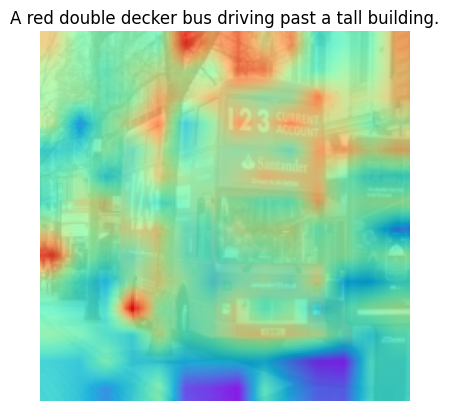

In [56]:
if cls_attn_map is not None:
    plt.imshow(img)
    plt.imshow(cls_attn_map[0].detach().cpu(), alpha=0.8, cmap="rainbow")
    plt.title(description)
    plt.axis("off")
    plt.show()
else:
    print("No CLS token attention map for this encoder architecture.")

## Patch Attention Map - Self-Attention among Patches

* Effectively visualizing:
    $$ A_{patch \to patch} \in \mathbb{R}^{196 \times 196} $$

* Answers the questions: 
  * "How strongly do patches attend to each other?" (`patch_attn_map`)
  * "Which patches are globally influential in the learned image representation?" (`patch_saliency_map`)

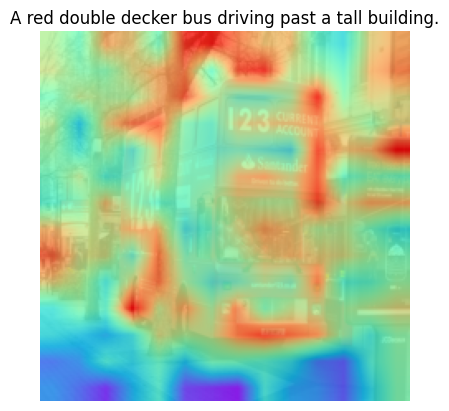

In [57]:
plt.imshow(img)
plt.imshow(patch_saliency_map[0].detach().cpu(), alpha=0.8, cmap="rainbow")
plt.title(description)
plt.axis("off")
plt.show()

In [58]:
# grid of attention heads
num_heads = len(maps_processed_patch)
grid_size = int(np.ceil(np.sqrt(num_heads)))

## CLS Attention Map per Head

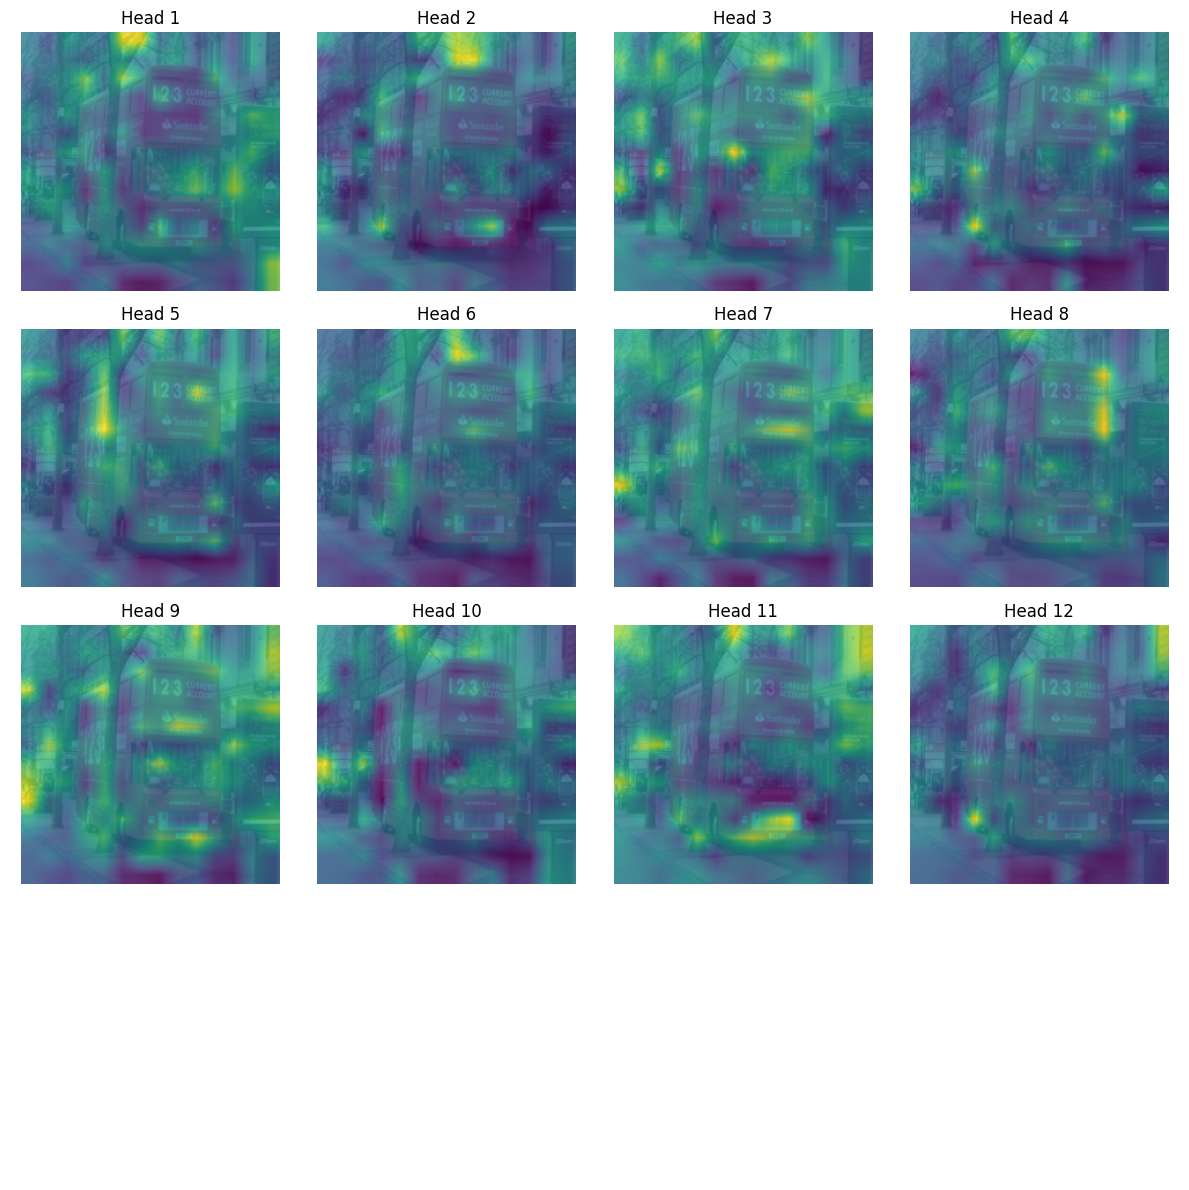

In [59]:
if maps_processed_cls is not None:    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            head_idx = i * grid_size + j
            if head_idx < num_heads:
                ax.imshow(img)
                ax.imshow(maps_processed_cls[head_idx], alpha=0.8, cmap="viridis")
                ax.set_title(f'Head {head_idx+1}')
            ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No CLS token attention maps for this encoder architecture.")

## Patch Attention Map per Head

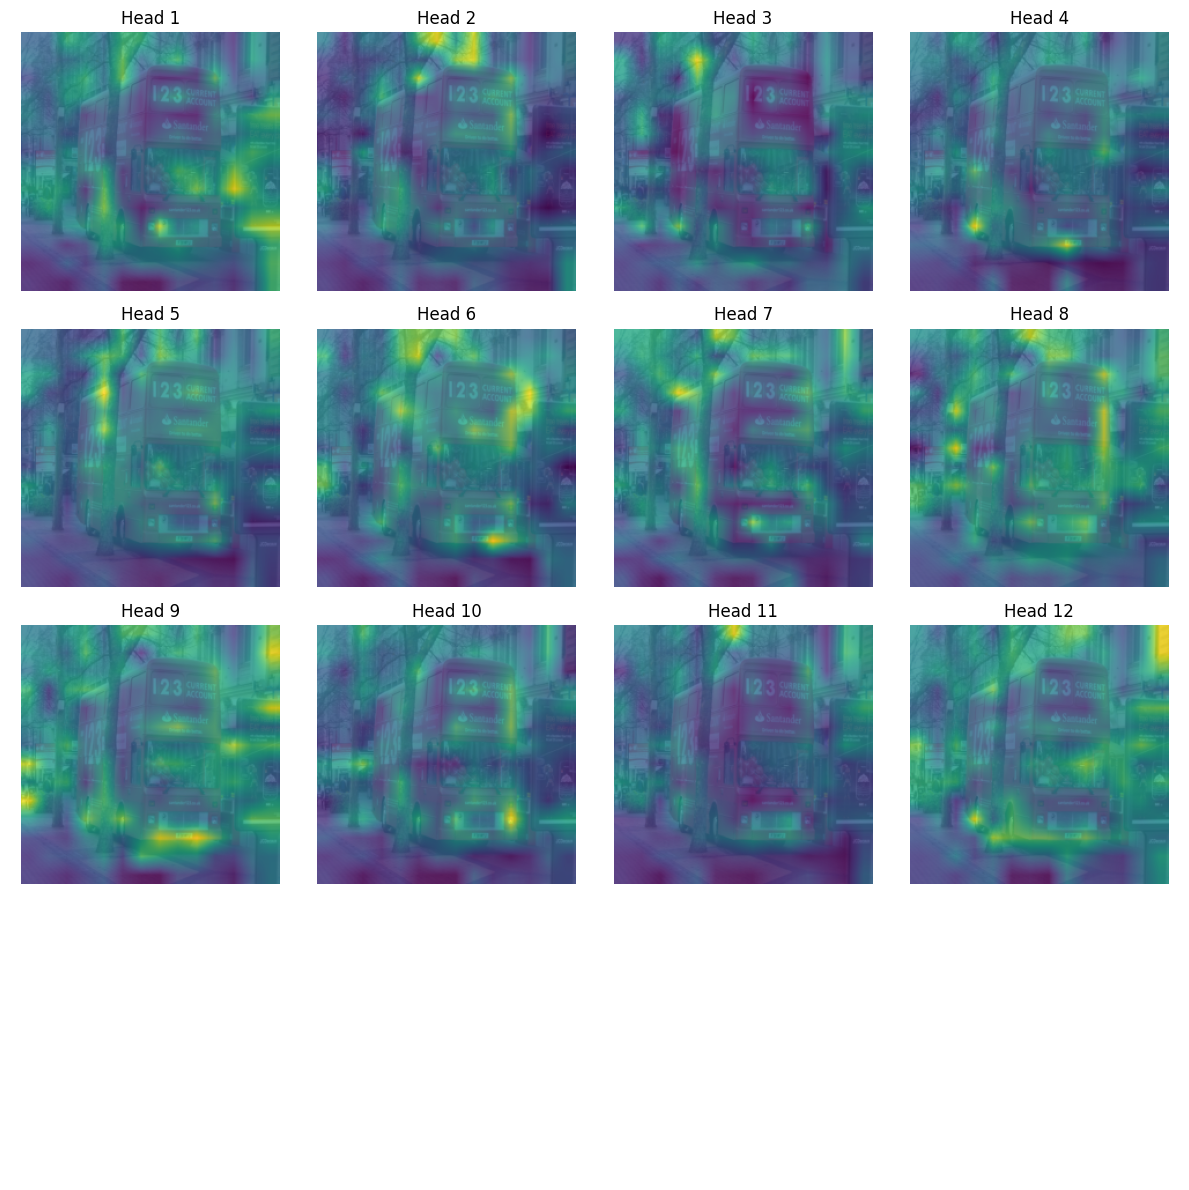

In [60]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        head_idx = i * grid_size + j
        if head_idx < num_heads:
            ax.imshow(img)
            ax.imshow(maps_processed_patch[head_idx], alpha=0.8, cmap="viridis")
            ax.set_title(f'Head {head_idx+1}')
        ax.axis("off")
plt.tight_layout()
plt.show()